In [96]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
import torch
np.set_printoptions(precision=17)

# Dope Plotting Code I Found

In [45]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    Use '\showthe\textwidth' in latex and find the same command in log.
    https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "autodiff":
        width_pt = 469.75499
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# Need to use r strings 
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [97]:
# Random functions
def parse_scientific(val):
    # Parse 1.0E-15 into ("1","-15") and 1.4E+12 into ("1.4","12")
    if val == 0:
        return 0,0
    estr = f"{val:.1E}".split("E")
    e_exp = estr[1] if estr[1][0] == '-' else estr[1][1:]
    e_num = estr[0][0] if estr[0].split('.')[1] == '0' else estr[0]
    return e_num,e_exp

def latex_scientific(val):
    e_num, e_exp = parse_scientific(val)
    if e_num == 0 and e_exp == 0:
        return "0"
    e_str = rf"10^{'{'}{e_exp}{'}'}"
    if e_num != "1":
        e_str = rf"{e_num}\times" + e_str
    return e_str

for i in ['','1','2','3','4']:
    os.makedirs(f"h_removable/h{i}", exist_ok=True)
    os.makedirs(f"hp_removable/h{i}p", exist_ok=True)
    os.makedirs(f"hp_removable_torch/h{i}p", exist_ok=True)
    os.makedirs(f"hp_removable_tensorflow/h{i}p", exist_ok=True)

# Constants

In [98]:
COLORS = sns.color_palette("tab10", 10) # TODO: Green Yellow Red
NUM_UNDERFLOW_COLOR = COLORS[1] # Yellow 
DEN_UNDERFLOW_COLOR = COLORS[0] # Blue
BOTH_UNDERFLOW_COLOR = COLORS[3] # Red
NO_UNDERFLOW_COLOR = COLORS[2] # Green
COLOR_ENUM = [(NO_UNDERFLOW_COLOR,"No Underflow"),(NUM_UNDERFLOW_COLOR,"Numerator Underflow"),
              (DEN_UNDERFLOW_COLOR,"Denominator Underflow"),(BOTH_UNDERFLOW_COLOR,"Both Underflow")]

# Functions of Interest

In [183]:
def f(x):
    #return np.power(x,2) - 4
    return x**2 - 4

def fp(x):
    return 2*x 

def g(x):
    return x-2

def gp(x):
    return 1

def sign(x,case_zero=0):
    if x > 0:
        return 1
    if x < 0:
        return -1
    if x == 0:
        return case_zero
    
def h(x,f,g):
    return f(x) / g(x)

def h_under(gamma,e,d,f,g,*args):
    num_underflow = f(2+gamma) == ((2+gamma)**2 - gamma**2)-4 and gamma != 0
    den_underflow = g(2+gamma) == 0 and gamma != 0
    return num_underflow, den_underflow

def hp_q(x,f,fp,g,gp):
    return (fp(x)*g(x) - f(x)*gp(x))/(g(x)**2)

def hp_p(x,f,fp,g,gp):
    return fp(x)/g(x) - f(x)*gp(x)/(g(x)**2) 

# 2x(x-2) - (x^2 - 4)
# 2(2 + gamma)(2 + gamma - 2) - ((2 + gamma)^2 - 4)
# x^2 - 4x + 4 = (x-2)^2 
# gamma^2

def hp_under(gamma,e,d,f,fp,g,gp,*args):
    # TODO: Expand out numerator and figure out which term drops first.
    num_underflow = fp(2+gamma) != gamma**2 #and gamma != 0 
    den_underflow = g(2+gamma)**2 == 0 and gamma != 0
    print("{:3e} {:4} {:4} {:15e} {:15e} {:15e} ".format(gamma, num_underflow, den_underflow, fp(2+gamma)*g(2+gamma) - f(2+gamma)*gp(2+gamma), g(2+gamma)**2,gamma**2))
    return num_underflow, den_underflow

#######################
######### h1 ##########
#######################

def h1(x,epsilon,delta,f,g,sign,case_zero):
    fx = f(x)
    gx = g(x)
    if 2-delta < x < 2 + delta:
        return fx/(gx + sign(gx,case_zero)*epsilon)
    return fx/gx

def h1p_q(x,epsilon,delta,f,fp,g,gp,sign,case_zero):
    fx = f(x)
    gx = g(x)
    fpx = fp(x)
    gpx = gp(x)
    if 2-delta < x < 2+delta:
        denom = (gx + sign(gx,case_zero)*epsilon)
        return (fpx*denom - fx*gpx)/denom**2
        #return fpx/(gx + sign(gx,case_zero)*epsilon) - fx*gpx/((gx + sign(gx,case_zero)*epsilon)**2)
    return (fpx*gx - fx*gpx)/(gx**2)

def h1p_p(x,epsilon,delta,f,fp,g,gp,sign,case_zero):
    fx = f(x)
    gx = g(x)
    fpx = fp(x)
    gpx = gp(x)
    if 2-delta < x < 2+delta:
        return fpx/(gx + sign(gx,case_zero)*epsilon) - fx*gpx/((gx + sign(gx,case_zero)*epsilon)**2)
    return fpx/gx - fx*gpx/(gx**2) 

#######################
######### h2 ##########
#######################

def h2(x,epsilon,delta,f,g,sign,case_zero):
    fx = f(x)
    gx = g(x)
    if 2 - delta < x-2 < 2 + delta:
        return fx/(sign(gx,case_zero)*epsilon)
    return fx/gx

def h2p_q(x,epsilon,delta,f,fp,g,gp,sign,case_zero):
    fx = f(x)
    gx = g(x)
    fpx = fp(x)
    gpx = gp(x)
    if 2 - delta < x < 2 + delta:
        return fpx/(sign(gx,case_zero)*epsilon) 
    return (fpx*gx - fx*gpx)/(gx**2)

def h2p_p(x,epsilon,delta,f,fp,g,gp,sign,case_zero):
    fx = f(x)
    gx = g(x)
    fpx = fp(x)
    gpx = gp(x)
    if 2 - delta < x < 2 + delta:
        return fpx/(sign(gx,case_zero)*epsilon) 
    return fpx/gx - fx*gpx/(gx**2)

#######################
######### h3 ##########
#######################

def h3(x,epsilon,delta,f,g,sign,case_zero):
    fx = f(x)
    gx = g(x)
    if - epsilon < gx < epsilon:
        return fx/(sign(gx,case_zero)*epsilon)
    return fx/gx

def h3p_q(x,epsilon,delta,f,fp,g,gp,sign,case_zero):
    fx = f(x)
    gx = g(x)
    fpx = fp(x)
    gpx = gp(x)
    if - epsilon < gx < epsilon:
        return fpx/(sign(gx,case_zero)*epsilon) 
    return (fpx*gx - fx*gpx)/(gx**2)

def h3p_p(x,epsilon,delta,f,fp,g,gp,sign,case_zero):
    fx = f(x)
    gx = g(x)
    fpx = fp(x)
    gpx = gp(x)
    if - epsilon < gx < epsilon:
        return fpx/(sign(gx,case_zero)*epsilon) 
    return fpx/gx - fx*gpx/(gx**2)

#######################
######### h4 ##########
#######################

def h4(x,epsilon,delta,f,g,sign,case_zero):
    fx = f(x)
    gx = g(x)
    if - epsilon < gx < 0:
        return fx/(-epsilon)
    elif 0 <= gx < epsilon:
        return fx/epsilon
    return fx/gx

def h4p_q(x,epsilon,delta,f,fp,g,gp,sign,case_zero):
    fx = f(x)
    gx = g(x)
    fpx = fp(x)
    gpx = gp(x)
    if - epsilon < gx < 0:
        return fpx/(-epsilon)
    elif 0 <= gx < epsilon:
        return fpx/epsilon
    return (fpx*gx - fx*gpx)/(gx**2)

def h4p_p(x,epsilon,delta,f,fp,g,gp,sign,case_zero):
    fx = f(x)
    gx = g(x)
    fpx = fp(x)
    gpx = gp(x)
    if - epsilon < gx < 0:
        return fpx/(-epsilon)
    elif 0 <= gx < epsilon:
        return fpx/epsilon
    return fpx/gx - fx*gpx/(gx**2)

#######################
######### aux #########
#######################

def h_color(num_underflow, den_underflow):
    if num_underflow and den_underflow:  # NaN
        return BOTH_UNDERFLOW_COLOR # Orange
    if num_underflow:
        return NUM_UNDERFLOW_COLOR # Green
    if den_underflow:
        return DEN_UNDERFLOW_COLOR # Red
    return NO_UNDERFLOW_COLOR    # Blue

def call_h_color(x,hfunc,*args):
    c = []
    for i in range(len(x)):
        c.append(h_color(*hfunc(x[i],*args)))
    return c

def call_h(x,hfunc,*args):
    y = np.empty_like(x)
    for i in range(len(x)):
        y[i] = hfunc(x[i],*args)
    return y


def call_h_torch(x,hfunc,*args):
    y = torch.empty(len(x),dtype=torch.float64)
    for i in range(len(x)):
        xt = torch.tensor([x[i]], requires_grad=True)
        out = hfunc(xt,*args)
        out.backward()
        y[i] = xt.grad
    return y.numpy()


def call_h_tf(x,hfunc,*args):
    y = np.empty_like(x)
    for i in range(len(x)):
        xt = tf.Variable(x[i],dtype=tf.float64)
        with tf.GradientTape() as tape:
            out = hfunc(xt,*args)
        y[i] = tape.gradient(out,xt)
    return y

def verify_h(x,hfunc,thresh,*args):
    for i in range(len(x)):
        vals = {hf(x[i],*args) for hf in hfunc}
        if len(vals) == 2:
            v1,v2 = list(vals)
            if np.abs(v1 - v2) < thresh:
                continue
        if len(vals) > 1:
            print(f"Error: for x = {x[i]:.16e} values differ")
            print(f"Epsilon = {args[0]:.3e}\nDelta = {args[1]:.3e}")
            for hf in hfunc:
                print(f"\t{hf.__name__:10} : {hf(x[i],*args):.16e}")
            return
    print("All functions equivalent over provided x values")


# Plotting Code

In [153]:
def get_x(start_exp=0,end_exp=20,step=0.5,include_zero=True):
    spacing = np.power(10,-np.arange(start_exp,end_exp+step,step,dtype=np.float64))
    if include_zero:
        return np.concatenate((-spacing,[0],np.flip(spacing)))
    return np.concatenate((-spacing,np.flip(spacing)))

def scatter_plot(x,y,title,xlabel,ylabel,xticks=None,yticks=None,log_y=True,linthresh=1e-20,
                 plot_nan=None,frac=1,s=0.1,c=None,**kwargs):
    fig, ax = plt.subplots(figsize = set_size("autodiff", fraction=frac, subplots=(1, 1)))
    if c is None:
        ax.scatter(x,y,s=s,**kwargs)
    else:  
        for col, l in COLOR_ENUM:
            loc = np.all(np.array(c)==col,axis=1)
            if np.sum(loc) > 0 and not np.all(loc == np.isnan(y)):
                ax.scatter(x[loc],y[loc],c=col,s=s,label=l,**kwargs)
        if plot_nan is None:
            ax.legend()
    if not plot_nan is None:
        nan_x = x[np.isnan(y)]
        nan_left = np.min(nan_x)
        nan_right = np.max(nan_x)
        center = 0 if log_y else 4
        center = 1 if "deriv" in plot_nan else center
        if "shade" in plot_nan:
            ax.axvspan(nan_left, nan_right, color=COLORS[5],alpha=0.2,label="NaN Region")
        if not "text" in plot_nan and not "shade" in plot_nan:
            ax.scatter(nan_x,center*np.ones(np.sum(np.isnan(y))),s=s,marker='x',c=COLORS[5],label="NaN")
        ax.legend()
        if "text" in plot_nan:
            plt.annotate("NaN",xy=(0,center),ha="center",c=BOTH_UNDERFLOW_COLOR)
            
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale("symlog",linthresh=linthresh)
    if log_y:
        ax.set_yscale("symlog",linthresh=linthresh)
    if not xticks is None:
        ax.set_xticks(xticks)
    if not yticks is None:
        ax.set_yticks(yticks)
    return fig,ax

## Verifying functions

In [192]:
def h2_2x(x,epsilon,delta,f,g,sign,case_zero):
    fx = f(x)
    gx = g(x)
    if -delta < x-2 < delta:
        return fx/(sign(gx,case_zero)*epsilon)
    return fx/gx

def h2_2d(x,epsilon,delta,f,g,sign,case_zero):
    fx = f(x)
    gx = g(x)
    if 2-delta < x < 2+delta:
        return fx/(sign(gx,case_zero)*epsilon)
    return fx/gx

xtest = get_x(0,20,0.01,include_zero=True) + 2
eps_test = [1e-4,1e-8,1e-12]
for e in eps_test:
    verify_h(xtest,[h2_2d,h3,h4],1e-7,e,e,f,g,sign,1)
    verify_h(xtest,[h2_2d,h3,h4],1e-8,e,e,f,g,sign,1)
    verify_h(xtest,[h2_2x,h3,h4],1e-20,e,e,f,g,sign,1)
    print()

All functions equivalent over provided x values
All functions equivalent over provided x values
All functions equivalent over provided x values

All functions equivalent over provided x values
Error: for x = 1.9999999900000001e+00 values differ
Epsilon = 1.000e-08
Delta = 1.000e-08
	h2_2d      : 4.0000000000000000e+00
	h3         : 3.9999999756901161e+00
	h4         : 3.9999999756901161e+00
All functions equivalent over provided x values

All functions equivalent over provided x values
All functions equivalent over provided x values
All functions equivalent over provided x values



# Looking for the jittering

/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/3774286442.py:23: RuntimeWarning: invalid value encountered in divide
  return f(x) / g(x)


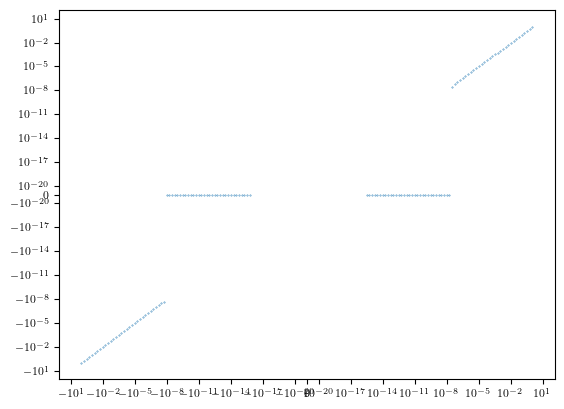

-1.000000000000000e+00 : -1.000000000000000e+00 : -3.000000000000000e+00 : -1.000000000000000e+00 :  3.000000000000000e+00
-5.623413251903491e-01 : -5.623413251903493e-01 : -1.933137534744558e+00 : -5.623413251903491e-01 :  3.437658674809651e+00
-3.162277660168379e-01 : -3.162277660168380e-01 : -1.164911064067352e+00 : -3.162277660168380e-01 :  3.683772233983162e+00
-1.778279410038923e-01 : -1.778279410038928e-01 : -6.796889874138854e-01 : -1.778279410038923e-01 :  3.822172058996107e+00
-1.000000000000000e-01 : -1.000000000000023e-01 : -3.900000000000001e-01 : -1.000000000000001e-01 :  3.899999999999998e+00
-5.623413251903491e-02 : -5.623413251903342e-02 : -2.217742524159716e-01 : -5.623413251903497e-02 :  3.943765867480967e+00
-3.162277660168379e-02 : -3.162277660168034e-02 : -1.254911064067357e-01 : -3.162277660168389e-02 :  3.968377223398320e+00
-1.778279410038923e-02 : -1.778279410039385e-02 : -7.081494863553983e-02 : -1.778279410038919e-02 :  3.982217205899606e+00
-1.0000000000000

/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/3774286442.py:23: RuntimeWarning: invalid value encountered in double_scalars
  return f(x) / g(x)


In [201]:
gamma = get_x(0,20,0.25,include_zero=True) 
y = h(2+gamma,f,g)-4

plt.scatter(gamma,y,s=0.1)
plt.gca().set_xscale("symlog",linthresh=1e-20)
plt.gca().set_yscale("symlog",linthresh=1e-20)
plt.show()

for i in range(len(gamma)):
    print(f"{gamma[i]:22.15e} : {y[i]:22.15e} : {f(2+gamma[i]):22.15e} : {g(2+gamma[i]):22.15e} : {h(2+gamma[i],f,g):22.15e}")

# Data Generation

In [202]:
gamma = get_x(0,20,0.25,include_zero=True) 
save_loc = "h_removable/{:}"
S = 1
H = [h1, h2, h3, h4]

# h(x)
def plot_h(gamma,f,g,frac=1,s=1,c=None,plot_nan=None,no_title=False,ylabel_hx=False):
    y = h(2 + gamma,f,g)
    if not c is None:
        c = call_h_color(gamma,h_under,0,0,f,g)
    title = r"Plot $h(2 + \gamma){:}$" if not no_title else ""
    xlabel = "$\gamma$"
    ylabel = "$h(2+\gamma){:}$" if not ylabel_hx else "$h(x){:}$"
    nan_str = '' if plot_nan is None else "nan"
    ticks = get_x(0,18,6)
    fig,ax = scatter_plot(gamma,y,title.format(''),xlabel,ylabel.format(''),xticks=ticks,log_y=False,s=s,c=c,frac=frac,plot_nan=plot_nan)
    fig.savefig(save_loc.format(f"h/y{nan_str}.pdf"),dpi=300,format="pdf",bbox_inches='tight')
    plt.close()
    fig,ax = scatter_plot(gamma,y-4,title.format("-4"),xlabel,ylabel.format("-4"),xticks=ticks,yticks=ticks,log_y=True,s=s,c=c,frac=frac,plot_nan=plot_nan)
    fig.savefig(save_loc.format(f"h/y-4{nan_str}.pdf"),dpi=300,format="pdf",bbox_inches='tight')
    plt.close()

def plot_hi(gamma,hindex,epsilon,delta,f,g,sign,frac=1,s=1,c=None,format_exp=True,no_title=False,ylabel_hx=False):
    # epsilon, delta must be lists.  hi,f,g,sign are functions
    hi = H[hindex-1]
    for e in epsilon:
        for d in delta:
            for cz in [-1,1]:
                # Data
                y = call_h(2+gamma,hi,e,d,f,g,sign,cz)
                if not c is None:
                    c = call_h_color(gamma,h_under,e,d,f,g,sign,cz)
                # Strings and Args
                if format_exp:
                    eps_str = latex_scientific(e)
                    del_str = latex_scientific(d)
                else:
                    eps_str = f"{e:.1E}"
                    del_str = f"{d:.1E}"
                title = rf"Plot $h_{hindex}(2 + \gamma)$, with $\epsilon = {eps_str}$, $\delta = {del_str}$"
                title4 = rf"Plot $h_{hindex}(2 + \gamma)-4$, with $\epsilon = {eps_str}$, $\delta = {del_str}$"
                if no_title:
                    title = ''
                    title4 = ''
                xlabel = r"$\gamma$"
                ylabel = rf"$h_{hindex}(2+\gamma)$" if not ylabel_hx else rf"$h_{hindex}(x)$"
                ylabel4 = rf"$h_{hindex}(2+\gamma)-4$" if not ylabel_hx else rf"$h_{hindex}(x)-4$"
                ticks = get_x(0,18,6)
                # Plotting
                fig,ax = scatter_plot(gamma,y,title,xlabel,ylabel,xticks=ticks,log_y=False,s=s,c=c,frac=frac)
                fig.savefig(save_loc.format(rf"h{hindex}/y_eps_{e:.1E}_delta_{d:.1E}_cz_{cz}.pdf"),dpi=300,format="pdf",bbox_inches='tight')
                plt.close()
                fig,ax = scatter_plot(gamma,y-4,title4,xlabel,ylabel4,xticks=ticks,yticks=ticks,log_y=True,s=s,c=c,frac=frac)
                fig.savefig(save_loc.format(rf"h{hindex}/y-4_eps_{e:.1E}_delta_{d:.1E}_cz_{cz}.pdf"),dpi=300,format="pdf",bbox_inches='tight')
                plt.close()

# [1e-4,1e-8,1e-12]
plot_h(gamma,f,g,s=S,c=True,no_title=True,ylabel_hx=True,plot_nan="text")

for i in range(1,5):
    plot_hi(gamma,i,[1e-4,1e-8,1e-12],[1e-4,1e-8,1e-12],f,g,sign,s=S,c=True,format_exp=True,ylabel_hx=True,no_title=True)


/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/3774286442.py:23: RuntimeWarning: invalid value encountered in divide
  return f(x) / g(x)
/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/3154929170.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[loc],y[loc],c=col,s=s,label=l,**kwargs)


# Plotting $h'$

In [144]:
gamma = get_x(0,20,0.01,include_zero=True) 
save_loc = "hp_removable/{:}"
S = 5
HPQ = [h1p_q, h2p_q, h3p_q, h4p_q]
HPP = [h1p_p, h2p_p, h3p_p, h4p_p]

# h(x)
def plot_hp(gamma,f,fp,g,gp,frac=1,s=1,c=None,plot_nan=None,no_title=False):
    yp = hp_p(2+gamma,f,fp,g,gp)
    yq = hp_q(2+gamma,f,fp,g,gp)
    if not c is None:
        c = call_h_color(gamma,h_under,0,0,f,fp,g,gp)
    title = "Plot $h'(2 + \gamma)$, {:} Rule" if not no_title else ''
    xlabel = "$\gamma$"
    ylabel = "$h'(2+\gamma)$"
    nan_str = '' if plot_nan is None else "nan"
    ticks = get_x(0,18,6)
    fig,ax = scatter_plot(gamma,yp,title.format("Product"),xlabel,ylabel,xticks=ticks,log_y=False,s=s,c=c,frac=frac,plot_nan=plot_nan)
    fig.savefig(save_loc.format(rf"hp/p{nan_str}.pdf"),dpi=300,format="pdf",bbox_inches='tight')
    plt.close()
    fig,ax = scatter_plot(gamma,yq,title.format("Quotient"),xlabel,ylabel,xticks=ticks,log_y=False,s=s,c=c,frac=frac,plot_nan=plot_nan)
    fig.savefig(save_loc.format(rf"hp/q{nan_str}.pdf"),dpi=300,format="pdf",bbox_inches='tight')
    plt.close()

# hi(x)
def plot_hip(gamma,hindex,p_or_q,epsilon,delta,f,fp,g,gp,sign,frac=1,s=1,c=None,format_exp=True,no_title=False):
    # epsilon, delta must be lists.  hi,f,g,sign are functions
    if p_or_q == 'q':
        hip = HPQ[hindex-1]
    elif p_or_q == 'p':
        hip = HPP[hindex-1]
    else:
        return
    for e in epsilon:
        for d in delta:
            for cz in [-1,1]:
                # Data
                y = call_h(2+gamma,hip,e,d,f,fp,g,gp,sign,cz)
                if not c is None:
                    c = call_h_color(gamma,h_under,e,d,f,g,sign,cz)
                # Strings and Args
                if format_exp:
                    eps_str = latex_scientific(e)
                    del_str = latex_scientific(d)
                else:
                    eps_str = f"{e:.1E}"
                    del_str = f"{d:.1E}"
                pq = "Quotient Rule" if p_or_q == 'q' else "Product Rule"
                title = rf"Plot $h_{hindex}'(2 + \gamma)$ ({pq}), with $\epsilon = {eps_str}$, $\delta = {del_str}$"
                if no_title:
                    title = ''
                xlabel = r"$\gamma$"
                ylabel = rf"$h_{hindex}'(2+\gamma)$"
                ticks = get_x(0,18,6)
                # Plotting
                fig,ax = scatter_plot(gamma,y,title,xlabel,ylabel,xticks=ticks,log_y=False,s=s,c=c,frac=frac)
                fig.savefig(save_loc.format(rf"h{hindex}p/{p_or_q}_eps_{e:.1E}_delta_{d:.1E}_cz_{cz}.pdf"),dpi=300, format="pdf", bbox_inches='tight')
                plt.close()

plot_hp(gamma,f,fp,g,gp,s=S,c=True)#,plot_nan="textshadederiv")
for i in range(1,-1):
    plot_hip(gamma,i,'p',[1e-4,1e-8,1e-12],[1e-4,1e-8,1e-12],f,fp,g,gp,sign,s=S,c=True,format_exp=True)
    plot_hip(gamma,i,'q',[1e-4,1e-8,1e-12],[1e-4,1e-8,1e-12],f,fp,g,gp,sign,s=S,c=True,format_exp=True)

/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/1959798011.py:34: RuntimeWarning: divide by zero encountered in divide
  return fp(x)/g(x) - f(x)*gp(x)/(g(x)**2)
/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/1959798011.py:34: RuntimeWarning: invalid value encountered in divide
  return fp(x)/g(x) - f(x)*gp(x)/(g(x)**2)
/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/1959798011.py:31: RuntimeWarning: invalid value encountered in divide
  return (fp(x)*g(x) - f(x)*gp(x))/(g(x)**2)
/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/3154929170.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[loc],y[loc],c=col,s=s,label=l,**kwa

# Plotting $h'$ through Torch and Tensorflow

In [123]:
gamma = get_x(0,20,0.01,include_zero=True) 
save_loc_torch = "hp_removable_torch/{:}"
save_loc_tf = "hp_removable_tensorflow/{:}"
S = 1
H = [h1, h2, h3, h4]

# h(x)
def plot_hp_pkg(gamma,f,g,loc,frac=1,s=1,c=None,plot_nan=None,no_title=False):
    if "torch" in loc:
        y = call_h_torch(2+gamma,h,f,g)
    elif "tensorflow" in loc:
        y = call_h_tf(2+gamma,h,f,g)
    else:
        return 
    if not c is None:
        c = call_h_color(gamma,h_under,0,0,f,fp,g,gp)
    title = "Plot $h'(2 + \gamma)$ from "
    title += "Torch" if "torch" in loc else "Tensorflow"
    if no_title:
        title = ''
    xlabel = "$\gamma$"
    ylabel = "$h'(2+\gamma)$"
    nan_str = '' if plot_nan is None else "nan"
    ticks = get_x(0,18,6)
    fig,ax = scatter_plot(gamma,y,title,xlabel,ylabel,xticks=ticks,log_y=False,s=s,c=c,frac=frac,plot_nan=plot_nan)
    fig.savefig(loc.format(rf"hp/y{nan_str}.pdf"),dpi=300,format="pdf",bbox_inches='tight')
    plt.close()

# hi(x)
def plot_hip_pkg(gamma,hindex,epsilon,delta,f,g,sign,loc,frac=1,s=1,c=None,format_exp=True,no_title=False):
    # epsilon, delta must be lists.  hi,f,g,sign are functions
    hi = H[hindex-1]
    for e in epsilon:
        for d in delta:
            for cz in [-1,1]:
                # Data
                if "torch" in loc:
                    y = call_h_torch(2+gamma,hi,e,d,f,g,sign,cz)
                elif "tensorflow" in loc:
                    y = call_h_tf(2+gamma,hi,e,d,f,g,sign,cz)
                else:
                    return 
                #y = call_h_torch(2+gamma,hi,e,d,f,fp,g,gp,sign,cz)
                if not c is None:
                    c = call_h_color(gamma,h_under,e,d,f,g,sign,cz)
                # Strings and Args
                if format_exp:
                    eps_str = latex_scientific(e)
                    del_str = latex_scientific(d)
                else:
                    eps_str = f"{e:.1E}"
                    del_str = f"{d:.1E}"
                pkg = "Torch" if "torch" in loc else "Tensorflow"
                title = rf"Plot $h_{hindex}'(2 + \gamma)$ from {pkg}, with $\epsilon = {eps_str}$, $\delta = {del_str}$"
                if no_title:
                    title = ''
                xlabel = r"$\gamma$"
                ylabel = rf"$h_{hindex}'(2+\gamma)$"
                ticks = get_x(0,18,6)
                # Plotting
                fig,ax = scatter_plot(gamma,y,title,xlabel,ylabel,xticks=ticks,log_y=False,s=s,c=c,frac=frac)
                fig.savefig(loc.format(rf"h{hindex}p/y_eps_{e:.1E}_delta_{d:.1E}_cz_{cz}.pdf"),dpi=300, format="pdf", bbox_inches='tight')
                plt.close()


save_loc = save_loc_tf
plot_hp_pkg(gamma,f,g,save_loc,s=S,c=True)#,plot_nan="textshadederiv")
for i in range(1,-1):
    plot_hip_pkg(gamma,i,[1e-4,1e-8,1e-12],[1e-4,1e-8,1e-12],f,g,sign,save_loc,s=S,c=True,format_exp=True)

/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/1850381811.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[loc],y[loc],c=col,s=s,label=l,**kwargs)


In [124]:
save_loc = save_loc_torch
plot_hp_pkg(gamma,f,g,save_loc,s=S,c=True)#,plot_nan="textshadederiv")
for i in range(1,-1):
    plot_hip_pkg(gamma,i,[1e-4,1e-8,1e-12],[1e-4,1e-8,1e-12],f,g,sign,save_loc,s=S,c=True,format_exp=True)

/var/folders/4m/h0cg42rn1h97wd6m1rckrp400000gn/T/ipykernel_36405/1850381811.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[loc],y[loc],c=col,s=s,label=l,**kwargs)
